In [1]:
# Import dependencies
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import tensorflow as tf
import pycaret
from pycaret.classification import *

## Load Data

In [2]:
import psycopg2
import pandas as pd

conn = psycopg2.connect(database = 'postgres',
                        user =     'postgres',
                        password = 'Arya7328*',
                        host =     'bootcampproject.cs8v5ggqsbn0.us-west-1.rds.amazonaws.com',
                        port =     '5432')

cur = conn.cursor()

cur.execute('''
            SELECT *
            FROM mltable;
            ''')

data = cur.fetchall()

# Create a dataframe
cols = []
for elt in cur.description:
    cols.append(elt[0])
        
health_df = pd.DataFrame (data=data,columns=cols)
pd.set_option('display.max_columns', None)
health_df.head(10)

,GENHLTH,MENTHLTH,PHYSHLTH,BPHIGH4,TOLDHI2,CVDINFR4,CVDCRHD4,CVDSTRK3,CHCSCNCR,CHCOCNCR,CHCCOPD1,HAVARTH3,CHCKIDNY,DIABETE3,SEX,MARITAL,EDUCA,RENTHOM1,VETERAN3,EMPLOY1,INCOME2,INTERNET,QLACTLM2,USEEQUIP,BLIND,DECIDE,DIFFWALK,DIFFDRES,DIFFALON,_RFHLTH,_HCVU651,_RFHYPE5,_CHOLCHK,_RFCHOL,_MICHD,_LTASTH1,_ASTHMS1,_DRDXAR1,_PRACE1,_AGEG5YR,_BMI5,_BMI5CAT,_CHLDCNT,_EDUCAG,_INCOMG,_DRNKWEK,_RFDRHV5,_FRTLT1,_VEGLT1,PA1MIN_,_PACAT1,_PAINDX1,_PAREC1
0,2,88,30,3,2,2,2,2,2,2,2,2,2,3,2,2,6,2,2,1,8,1,1,1,2,2,1,2,1,1,1,1,2,1,2,1,3,2,1,5,2213,2,1,4,5,0.0,1,1,1,0.0,4,2,3
1,3,88,88,3,2,2,2,2,2,2,2,2,2,3,2,1,6,1,2,1,99,1,2,2,2,2,2,2,2,1,1,1,1,1,2,1,3,2,4,7,2317,2,1,4,99,99.0,99,1,99,60.0,3,2,4
2,1,88,88,3,2,2,2,2,1,2,2,2,2,3,2,6,6,1,2,1,8,1,2,2,2,2,2,2,2,1,1,1,1,1,2,1,3,2,1,4,2569,3,1,4,5,200.0,1,1,1,600.0,1,1,1
3,1,88,88,1,7,2,2,2,2,2,7,2,2,3,2,99,5,2,2,6,99,1,2,2,2,2,2,2,2,1,1,2,1,99,2,1,3,2,1,1,1997,2,1,3,99,0.0,1,99,1,90.0,99,99,99
4,3,7,15,3,2,2,2,2,2,2,2,2,2,3,2,5,6,2,2,1,8,1,2,2,2,2,2,2,2,1,1,1,1,1,2,2,2,2,1,2,2362,2,1,4,5,0.0,1,2,1,420.0,1,1,2
5,2,1,4,3,1,2,2,2,2,2,2,2,2,3,2,1,4,1,2,99,8,1,2,2,2,2,2,2,2,1,1,1,1,2,2,1,3,2,2,8,3328,4,1,2,5,0.0,1,1,1,105.0,3,2,4
6,3,15,88,3,2,2,2,2,2,2,2,2,2,3,2,5,3,2,2,2,4,1,2,2,2,1,2,2,2,1,1,1,1,1,2,1,3,2,2,4,2510,3,6,1,2,0.0,1,1,1,2610.0,1,1,1
7,3,88,10,3,1,2,2,2,2,2,2,2,2,1,1,1,5,1,2,2,8,1,1,2,2,2,2,2,2,1,1,1,1,2,2,1,3,2,1,99,3835,4,1,3,5,0.0,1,2,1,210.0,2,1,2
8,2,88,88,3,1,2,2,2,2,2,2,2,2,3,1,1,3,1,2,1,8,1,2,2,2,2,2,2,2,1,1,1,1,2,2,1,3,2,1,4,2500,3,2,1,5,140.0,1,2,2,196.0,2,1,1
9,2,88,88,3,2,2,2,2,2,2,2,2,2,3,1,5,5,3,2,6,99,1,2,2,2,2,2,2,2,1,1,1,1,1,2,2,1,2,1,1,2399,2,1,3,99,300.0,1,1,1,30.0,3,2,3


## Preprocessing

In [4]:
# Check size and shape of table
health_df.shape

(222168, 53)

In [5]:
# Double check for null values
health_df.isna().sum().sum()

0

In [6]:
# Columns that need to be changed to categorical:
cat_cols = ['BPHIGH4','TOLDHI2','CVDINFR4','CVDCRHD4','CVDSTRK3','CHCSCNCR','CHCOCNCR','CHCCOPD1','HAVARTH3','CHCKIDNY',
            'DIABETE3','SEX','MARITAL','EDUCA','RENTHOM1','VETERAN3','EMPLOY1','INTERNET','QLACTLM2','USEEQUIP','BLIND',
            'DECIDE','DIFFWALK','DIFFDRES','DIFFALON','_RFHLTH','_HCVU651','_RFHYPE5','_CHOLCHK','_RFCHOL','_MICHD',
            '_LTASTH1','_ASTHMS1','_DRDXAR1','_PRACE1','_RFDRHV5','_FRTLT1','_VEGLT1','_PAINDX1','_PAREC1']

In [7]:
# Change column type to categorical where appropriate
for col in [cat_cols]:
    health_df[col] = health_df[col].astype('category')

In [8]:
# GENHLTH: values over 5 changed to median
for index, row in health_df.iterrows():
    if health_df.loc[index, 'GENHLTH'] > 5:
        health_df.loc[index, 'GENHLTH'] = health_df.GENHLTH.median()

In [10]:
# MENTHLTH: 88 changed to 0, 99 and over 30 changed to median
for index, row in health_df.iterrows():
    if health_df.loc[index, 'MENTHLTH'] == 88:
        health_df.loc[index, 'MENTHLTH'] = 0
    elif (health_df.loc[index, 'MENTHLTH'] == 99) or (health_df.loc[index,'MENTHLTH'] > 30):
        health_df.loc[index, 'MENTHLTH'] = health_df.MENTHLTH.median()

In [11]:
# _AGEG5YR: values over 13 changed to median
for index, row in health_df.iterrows():
    if health_df.loc[index, '_AGEG5YR'] > 13:
        health_df.loc[index, '_AGEG5YR'] = health_df._AGEG5YR.median()

In [13]:
# For the following columns, values over 8 changed to median
change_cols = ['INCOME2', '_CHLDCNT', '_EDUCAG', '_INCOMG', '_PACAT1']
for col in change_cols:
    for index, row in health_df.iterrows():
        if health_df.loc[index, col] > 8:
            health_df.loc[index, col] = health_df[col].median()

In [20]:
# _DRNKWEK: values over 1500 changed to median
for index, row in health_df.iterrows():
    if health_df.loc[index, '_DRNKWEK'] > 1500:
        health_df.loc[index, '_DRNKWEK'] = health_df._DRNKWEK.median()

array([[<AxesSubplot:title={'center':'MENTHLTH'}>]], dtype=object)

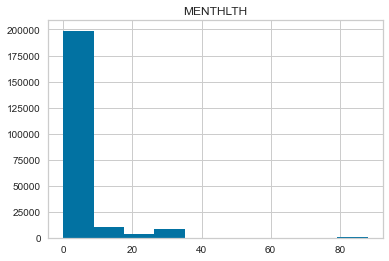

In [22]:
# Look at histogram of target (MentHlth) to decide bin ranges
health_df.hist(column='MENTHLTH')

In [24]:
# Create 2 bins for mental health. One at 0, one from 1-30
for index, row in health_df.iterrows():
    if health_df.loc[index,'MENTHLTH'] > 0:
        health_df.loc[index, 'MENTHLTH'] = 1

array([[<AxesSubplot:title={'center':'MENTHLTH'}>]], dtype=object)

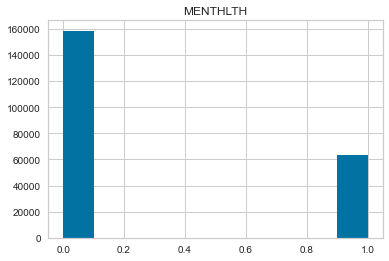

In [25]:
# Check target column bins
health_df.hist(column='MENTHLTH')

## Feature Engineering and Selection

In [ ]:
# Correlation matrix heatmap
import matplotlib.pyplot as plt
import seaborn as sns

# Ploting the heatmap for correlation
ax = sns.heatmap(health_df.corr().round(2), annot=True)

## Split and scale data

In [ ]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler and transform data
df_scaled = scaler.fit_transform(health_df)

In [ ]:
# Separate data into training and testing sets
data = df_scaled.sample(frac=0.9, random_state=0).reset_index(drop=True)
data_unseen = df_scaled.drop(data.index).reset_index(drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

## Compare machine learning models

In [ ]:
# Initialization setup
exp_clf101 = setup(data = data, target = 'MentHlth', session_id=123)

In [ ]:
# Model training and selection
best_model = compare_models()

## Tune _____ Model

In [ ]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=128, random_state=0)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)

In [ ]:
# Calculating the confusion matrix.
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# Calculating the accuracy score.
acc_score = accuracy_score(y_test, y_pred)

# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, y_pred))